<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np

from nlp.dataset import plot_frequencies, plot_roc, save_ngram_counts
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

In [2]:
DS_NAME = 'wikicorpus'
LIMIT_PROP = 0.03
prec = LIMIT_PROP * 100
DS_ITEM_COUNTS_PATH = f"./nlp/data/2_grams_wikicorpus_concat_{prec}%.npz"
CONCAT = True

In [3]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###
save_ngram_counts('wikicorpus', limit_prop=LIMIT_PROP,
                 n=2, tokens_key='sentence', concat=CONCAT, name='tagged_en')

Reusing dataset wikicorpus (/data/home/daniel_nlp/learning-ds/nlp/data/wikicorpus/tagged_en/0.0.0/f0403fa42ed08c5c71388dedc7c267c87c73d10584a0397170d3d5684038cc59)
  0%|          | 0/790508 [00:00<?, ?it/s]

Computing n-grams...


100%|██████████| 790508/790508 [03:05<00:00, 4272.34it/s]


Counting n-grams...


100%|██████████| 119975/119975 [00:01<00:00, 95622.63it/s]


Number of examples used: 790508
Number of bigrams: 1146052


(array(['external links', 'median income', '0 till', ..., 'untrimmed hair',
        'waheguru guard', 'ardas facing'], dtype='<U197'),
 array([16118,  2885,  1985, ...,     1,     1,     1]))

# actual bigrams frequency

there are 1146052 bigrams


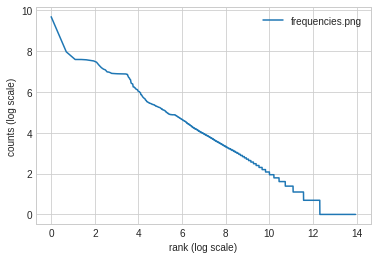

In [4]:
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies.png')

In [5]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('100 females', 1954), ('65 years', 1982), ('0 till', 1985), ('median income', 2885), ('external links', 16118)]
Bottom 5 frequent bigrams and their counts:
[('purely sacerdotal', 1), ('vehicle shall', 1), ('vehicle insignia', 1), ('vehicle trade', 1), ('vehicle proved', 1)]


# evaluating original count-min and count-sketch algorithms on data

In [6]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 22 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [16]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for ./nlp/data/2_grams_wikicorpus_concat_3.0%.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_min: # hashes 1, # buckets 225000 - loss 8.64	 time: 20.71 sec
count_min: # hashes 1, # buckets 175000 - loss 11.17	 time: 21.05 sec
count_min: # hashes 1, # buckets 25000 - loss 78.60	 time: 21.22 seccount_min: # hashes 1, # buckets 250000 - loss 7.78	 time: 21.02 seccount_min: # hashes 1, # buckets 350000 - loss 5.55	 time: 20.97 sec


count_min: # hashes 1, # buckets 75000 - loss 26.12	 time: 21.24 sec
count_min: # hashes 1, # buckets 500000 - loss 3.87	 time: 21.01 seccount_min: # hashes 1, # buckets 125000 - loss 15.65	 time: 21.21 sec

count_min: # hashes 1, # buckets 150000 - loss 13.02	 time: 21.20 sec
count_min: # hashes 1, # buckets 50000 - loss 39.34	 time: 21.36 sec
count_min: # hashes 1, # buckets 300000 - loss 6.46	 time: 21.18 sec
count_min: # hashes 1, # buckets 400000 - loss 4.84	 time: 21.15 sec
count_min: # has

In [17]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for ./nlp/data/2_grams_wikicorpus_concat_3.0%.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_min: # hashes 1, # buckets 300000 - loss 6.46	 time: 21.11 sec
count_min: # hashes 1, # buckets 25000 - loss 78.60	 time: 21.44 sec
count_min: # hashes 1, # buckets 200000 - loss 9.72	 time: 21.29 sec
count_min: # hashes 1, # buckets 75000 - loss 26.12	 time: 21.48 sec
count_min: # hashes 1, # buckets 500000 - loss 3.87	 time: 21.22 sec
count_min: # hashes 1, # buckets 100000 - loss 19.55	 time: 21.49 sec
count_min: # hashes 1, # buckets 450000 - loss 4.30	 time: 21.31 sec
count_min: # hashes 1, # buckets 50000 - loss 39.34	 time: 21.63 sec
count_min: # hashes 1, # buckets 400000 - loss 4.84	 time: 21.39 sec
count_min: # hashes 1, # buckets 125000 - loss 15.65	 time: 21.62 sec
count_min: # hashes 1, # buckets 250000 - loss 7.78	 time: 21.54 sec
count_min: # hashes 1, # buckets 350000 - loss 5.55	 time: 21.53 sec
count_min: # hash

# train estimation model

In [18]:
targets, preds = train_simple_model(DS_NAME, 
    config={
        "limit_prop": LIMIT_PROP,
        "concat": True,
        'num_workers': 10,

        "hidden_dim": 128,
        "dropout_prob": 0.0,

        "optim": Adam,
        "learning_rate": 0.0001,
        "batch_size": 128
        },
    args={
#         'gpus': 4,
        'max_epochs': 60
        })

Global seed set to 123
GPU available: True, used: False
TPU available: None, using: 0 TPU cores




HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'concat': True,
            'dropout_prob': 0.0,
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.03,
            'num_workers': 10,
            'optim': <class 'torch.optim.adam.Adam'>}}
{'ds_name': 'wikicorpus'}


Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_3.0%.npz


/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_3.0%_features.npz
Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_3.0%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_3.0%_features.npz



  | Name      | Type    | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | criterion | MSELoss | 0      | ?        | ?        
1 | l1        | Linear  | 25.7 K | [1, 200] | [1, 128] 
2 | dropout   | Dropout | 0      | [1, 1]   | [1, 1]   
3 | l2        | Linear  | 129    | [1, 128] | [1, 1]   
-------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.103     Total estimated model params size (MB)


Epoch 0:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.94it/s, loss=0.277, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 0:  99%|█████████▊| 6185/6269 [00:46<00:00, 132.15it/s, loss=0.277, v_num=8]


Epoch 1:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.26it/s, loss=0.273, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▊| 6180/6269 [00:47<00:00, 129.91it/s, loss=0.273, v_num=8]


Epoch 2:  57%|█████▋    | 3582/6269 [00:35<00:26, 99.63it/s, loss=0.269, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 6090/6269 [00:47<00:01, 127.50it/s, loss=0.269, v_num=8]


Epoch 3:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.28it/s, loss=0.266, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 6060/6269 [00:47<00:01, 128.07it/s, loss=0.266, v_num=8]


Epoch 4:  57%|█████▋    | 3582/6269 [00:34<00:26, 103.07it/s, loss=0.263, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 4:  96%|█████████▌| 6030/6269 [00:48<00:01, 124.56it/s, loss=0.263, v_num=8]


Epoch 5:  57%|█████▋    | 3582/6269 [00:35<00:26, 102.16it/s, loss=0.261, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 5:  95%|█████████▍| 5940/6269 [00:46<00:02, 128.20it/s, loss=0.261, v_num=8]


Epoch 6:  57%|█████▋    | 3582/6269 [00:34<00:25, 104.69it/s, loss=0.259, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 6:  94%|█████████▍| 5910/6269 [00:45<00:02, 130.42it/s, loss=0.259, v_num=8]


Epoch 7:  57%|█████▋    | 3582/6269 [00:34<00:25, 103.55it/s, loss=0.257, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 7:  94%|█████████▍| 5910/6269 [00:45<00:02, 130.13it/s, loss=0.257, v_num=8]


Epoch 8:  57%|█████▋    | 3582/6269 [00:35<00:26, 102.27it/s, loss=0.255, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 8:  94%|█████████▍| 5880/6269 [00:45<00:03, 128.10it/s, loss=0.255, v_num=8]


Epoch 9:  57%|█████▋    | 3582/6269 [00:35<00:26, 102.11it/s, loss=0.253, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 9:  92%|█████████▏| 5760/6269 [00:45<00:04, 125.63it/s, loss=0.253, v_num=8]


Epoch 10:  57%|█████▋    | 3582/6269 [00:33<00:25, 106.61it/s, loss=0.251, v_num=8]
Validating: 0it [00:00, ?it/s]
Validating:  77%|███████▋  | 2060/2687 [00:09<00:02, 246.61it/s]


Epoch 11:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.39it/s, loss=0.249, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 11:  89%|████████▊ | 5550/6269 [00:44<00:05, 124.36it/s, loss=0.249, v_num=8]


Epoch 12:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.76it/s, loss=0.248, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 12:  87%|████████▋ | 5460/6269 [00:44<00:06, 122.42it/s, loss=0.248, v_num=8]


Epoch 13:  57%|█████▋    | 3582/6269 [00:35<00:26, 102.19it/s, loss=0.246, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 13:  86%|████████▌ | 5400/6269 [00:43<00:07, 122.91it/s, loss=0.246, v_num=8]


Epoch 14:  57%|█████▋    | 3582/6269 [00:34<00:25, 103.51it/s, loss=0.245, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 14:  86%|████████▌ | 5394/6269 [00:43<00:07, 123.95it/s, loss=0.245, v_num=8]


Epoch 15:  57%|█████▋    | 3582/6269 [00:34<00:25, 103.65it/s, loss=0.243, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 15:  86%|████████▌ | 5394/6269 [00:43<00:07, 124.13it/s, loss=0.243, v_num=8]


Epoch 16:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.50it/s, loss=0.242, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 16:  85%|████████▍ | 5301/6269 [00:43<00:08, 120.89it/s, loss=0.242, v_num=8]


Epoch 17:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.91it/s, loss=0.241, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 17:  85%|████████▍ | 5301/6269 [00:43<00:08, 120.77it/s, loss=0.241, v_num=8]


Epoch 18:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.09it/s, loss=0.24, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 18:  85%|████████▍ | 5301/6269 [00:44<00:08, 119.67it/s, loss=0.24, v_num=8]


Epoch 19:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.97it/s, loss=0.239, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 19:  84%|████████▍ | 5270/6269 [00:43<00:08, 121.22it/s, loss=0.239, v_num=8]


Epoch 20:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.84it/s, loss=0.238, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 20:  83%|████████▎ | 5208/6269 [00:43<00:08, 119.45it/s, loss=0.238, v_num=8]


Epoch 21:  57%|█████▋    | 3582/6269 [00:37<00:27, 96.75it/s, loss=0.237, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 21:  82%|████████▏ | 5146/6269 [00:45<00:09, 114.07it/s, loss=0.237, v_num=8]


Epoch 22:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.90it/s, loss=0.236, v_num=8]
Validating: 0it [00:00, ?it/s]
Validating:  56%|█████▌    | 1504/2687 [00:07<00:04, 272.72it/s]


Epoch 23:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.64it/s, loss=0.235, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 23:  81%|████████  | 5053/6269 [00:42<00:10, 118.71it/s, loss=0.235, v_num=8]


Epoch 24:  57%|█████▋    | 3582/6269 [00:35<00:26, 102.18it/s, loss=0.234, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 24:  79%|███████▉  | 4960/6269 [00:42<00:11, 116.45it/s, loss=0.234, v_num=8]


Epoch 25:  57%|█████▋    | 3582/6269 [00:34<00:25, 104.23it/s, loss=0.233, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 28:  54%|█████▍    | 3396/6269 [00:31<00:26, 106.82it/s, loss=0.225, v_num=8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 29:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.67it/s, loss=0.229, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 29:  99%|█████████▉| 6200/6269 [00:47<00:00, 129.49it/s, loss=0.229, v_num=8]


Epoch 30:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.13it/s, loss=0.228, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 30:  98%|█████████▊| 6138/6269 [00:47<00:01, 129.49it/s, loss=0.228, v_num=8]


Epoch 31:  57%|█████▋    | 3582/6269 [00:34<00:25, 104.13it/s, loss=0.227, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 31:  97%|█████████▋| 6076/6269 [00:45<00:01, 132.14it/s, loss=0.227, v_num=8]


Epoch 32:  57%|█████▋    | 3582/6269 [00:34<00:26, 103.00it/s, loss=0.227, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 32:  96%|█████████▌| 6014/6269 [00:46<00:01, 129.52it/s, loss=0.227, v_num=8]


Epoch 33:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.23it/s, loss=0.226, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 33:  95%|█████████▌| 5983/6269 [00:46<00:02, 128.42it/s, loss=0.226, v_num=8]


Epoch 34:  57%|█████▋    | 3582/6269 [00:34<00:25, 104.72it/s, loss=0.225, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 34:  94%|█████████▍| 5890/6269 [00:45<00:02, 130.50it/s, loss=0.225, v_num=8]


Epoch 35:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.88it/s, loss=0.225, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 35:  92%|█████████▏| 5797/6269 [00:45<00:03, 126.78it/s, loss=0.225, v_num=8]


Epoch 36:  57%|█████▋    | 3582/6269 [00:35<00:26, 99.87it/s, loss=0.224, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 36:  91%|█████████ | 5704/6269 [00:46<00:04, 123.04it/s, loss=0.224, v_num=8]


Epoch 37:  57%|█████▋    | 3582/6269 [00:36<00:27, 97.97it/s, loss=0.223, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 37:  91%|█████████▏| 5735/6269 [00:46<00:04, 123.53it/s, loss=0.223, v_num=8]


Epoch 38:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.92it/s, loss=0.223, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 38:  90%|█████████ | 5673/6269 [00:45<00:04, 125.28it/s, loss=0.223, v_num=8]


Epoch 39:  57%|█████▋    | 3582/6269 [00:35<00:26, 99.81it/s, loss=0.222, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 39:  90%|████████▉ | 5611/6269 [00:45<00:05, 122.51it/s, loss=0.222, v_num=8]


Epoch 40:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.14it/s, loss=0.222, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 40:  89%|████████▊ | 5549/6269 [00:45<00:05, 123.04it/s, loss=0.222, v_num=8]


Epoch 41:  57%|█████▋    | 3582/6269 [00:36<00:27, 98.76it/s, loss=0.221, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 41:  87%|████████▋ | 5456/6269 [00:45<00:06, 119.48it/s, loss=0.221, v_num=8]


Epoch 42:  57%|█████▋    | 3582/6269 [00:34<00:25, 103.74it/s, loss=0.221, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 42:  86%|████████▌ | 5394/6269 [00:43<00:07, 123.25it/s, loss=0.221, v_num=8]


Epoch 43:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.98it/s, loss=0.22, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 43:  86%|████████▌ | 5363/6269 [00:44<00:07, 120.69it/s, loss=0.22, v_num=8]


Epoch 44:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.14it/s, loss=0.22, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 44:  85%|████████▌ | 5332/6269 [00:44<00:07, 119.12it/s, loss=0.22, v_num=8]


Epoch 45:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.64it/s, loss=0.219, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 45:  84%|████████▍ | 5270/6269 [00:44<00:08, 118.65it/s, loss=0.219, v_num=8]


Epoch 46:  57%|█████▋    | 3582/6269 [00:35<00:26, 99.59it/s, loss=0.219, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 46:  83%|████████▎ | 5208/6269 [00:44<00:09, 117.41it/s, loss=0.219, v_num=8]


Epoch 47:  57%|█████▋    | 3582/6269 [00:34<00:26, 102.62it/s, loss=0.218, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 47:  83%|████████▎ | 5177/6269 [00:43<00:09, 120.13it/s, loss=0.218, v_num=8]


Epoch 48:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.71it/s, loss=0.218, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 48:  82%|████████▏ | 5115/6269 [00:43<00:09, 118.27it/s, loss=0.218, v_num=8]


Epoch 49:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.92it/s, loss=0.217, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 49:  80%|███████▉  | 4991/6269 [00:43<00:11, 115.29it/s, loss=0.217, v_num=8]


Epoch 50:  57%|█████▋    | 3582/6269 [00:36<00:27, 99.46it/s, loss=0.217, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 50:  79%|███████▉  | 4960/6269 [00:43<00:11, 114.45it/s, loss=0.217, v_num=8]


Epoch 51:  57%|█████▋    | 3582/6269 [00:33<00:25, 106.48it/s, loss=0.217, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 51:  77%|███████▋  | 4836/6269 [00:40<00:12, 118.87it/s, loss=0.217, v_num=8]


Epoch 52:  57%|█████▋    | 3582/6269 [00:34<00:25, 105.11it/s, loss=0.216, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 52:  76%|███████▌  | 4743/6269 [00:40<00:13, 116.04it/s, loss=0.216, v_num=8]


Epoch 53:  57%|█████▋    | 3582/6269 [00:37<00:27, 96.34it/s, loss=0.216, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 53:  74%|███████▍  | 4650/6269 [00:43<00:15, 106.93it/s, loss=0.216, v_num=8]


Epoch 54:  57%|█████▋    | 3582/6269 [00:34<00:26, 103.00it/s, loss=0.216, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 54:  73%|███████▎  | 4588/6269 [00:40<00:14, 112.13it/s, loss=0.216, v_num=8]


Epoch 55:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.17it/s, loss=0.215, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 55:  72%|███████▏  | 4495/6269 [00:41<00:16, 109.47it/s, loss=0.215, v_num=8]


Epoch 56:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.61it/s, loss=0.215, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 56:  71%|███████   | 4433/6269 [00:40<00:16, 108.82it/s, loss=0.215, v_num=8]


Epoch 57:  57%|█████▋    | 3582/6269 [00:35<00:26, 101.44it/s, loss=0.215, v_num=8]
Validating: 0it [00:00, ?it/s]
Validating:  29%|██▉       | 791/2687 [00:04<00:07, 256.21it/s]


Epoch 58:  57%|█████▋    | 3582/6269 [00:35<00:26, 100.49it/s, loss=0.214, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 58:  69%|██████▉   | 4340/6269 [00:40<00:18, 105.96it/s, loss=0.214, v_num=8]


Epoch 59:  57%|█████▋    | 3582/6269 [00:36<00:27, 99.20it/s, loss=0.214, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 59:  67%|██████▋   | 4185/6269 [00:40<00:20, 102.52it/s, loss=0.214, v_num=8]


Epoch 59: 100%|██████████| 6269/6269 [00:49<00:00, 127.17it/s, loss=0.214, v_num=8]
Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_3.0%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_3.0%_features.npz
Testing: 100%|██████████| 2687/2687 [00:12<00:00, 216.37it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.23025505244731903}
--------------------------------------------------------------------------------
dumping test train and validation to:
train test valid
dumping test train and validation predictions to:
/data/home/daniel_nlp/learning-ds/nlp/pred_wikicorpus_concat_3.0%.npz


HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'concat': True,
            'dropout_prob': 0.0,
            'hidden_dim': 128,
            'learning_rate': 0.0001,
 

No Skill: ROC AUC=0.50
Learned: ROC AUC=0.85


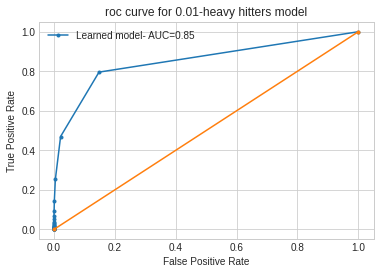

Saving plot...
Done.


<Figure size 432x288 with 0 Axes>

In [19]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [20]:
TEST_RESULTS =[f"./nlp/pred_wikicorpus_concat_{prec}%.npz"]
VALID_RESULTS = [f"./nlp/pred_wikicorpus_concat_{prec}%.npz"]
TEST_DATA = [f"./nlp/true_wikicorpus_test_concat_{prec}%.npz"]
VALID_DATA = [f"./nlp/true_wikicorpus_valid_concat_{prec}%.npz"]
LOOKUP_DATA = [f"./nlp/true_wikicorpus_train_concat_{prec}%.npz"]
SAVE ='cmin_wikicorpus'
SEED = 69
SPACE_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST = [1, 2, 3, 4]
PERFECT_ORDER = False
N_WORKERS = 20
DATA_NAME ='wikicorpus'
COUNT_SKETCH = False

In [21]:
# with lookup

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json

statistics for valid data:
./nlp/true_wikicorpus_valid_concat_3.0%.npz
data #: 343815, shape (343815,)
positive ratio: 1.76049, max 16118.000000, min 1.000000


statistics for test data:
./nlp/true_wikicorpus_test_concat_3.0%.npz
data #: 343815, shape (343815,)
positive ratio: 1.70885, max 1895.000000, min 1.000000


statistics for lookup data:
./nlp/true_wikicorpus_train_concat_3.0%.npz
data #: 458422, shape (458422,)
positive ratio: 1.71685, max 2885.000000, min 1.000000


data loading time: 1.2 sec
	loss_cf 0.00	loss_rd 26.26	loss_avg 26.26
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 26, # hashes 1, # cm buckets 22458 - loss 26.26	 time: 5.96 sec
	loss_cf 0.00	loss_rd 36.29	loss_avg 36.29
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 12, # hashes 1, # cm buckets 16602 - loss 36

lookup_table_count_min: s_cut: 6, # hashes 2, # cm buckets 1606 - loss 324.10	 time: 9.17 sec
	loss_cf 0.00	loss_rd 103.44	loss_avg 103.44
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 3, # cm buckets 4454 - loss 103.44	 time: 10.98 sec
	loss_cf 0.00	loss_rd 18.78	loss_avg 18.78
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 7, # hashes 1, # cm buckets 32330 - loss 18.78	 time: 6.57 sec
	loss_cf 0.00	loss_rd 478.58	loss_avg 478.58
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 6, # hashes 3, # cm buckets 1070 - loss 478.58	 time: 11.07 sec
	loss_cf 0.00	loss_rd 136.93	loss_avg 136.93
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 4, # cm buckets 3341 - loss 136.93	 time: 12.74 sec
	loss_cf 0.00	loss_rd 22.21	loss_avg 22.21
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 2, # cm buckets 19182 - loss 22.21	 time: 8.94 sec
	loss_cf 0.00	loss_rd 95.88	loss_avg 95.88
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 14, # 

lookup_table_count_min: s_cut: 8, # hashes 1, # cm buckets 110326 - loss 5.79	 time: 6.83 sec
	loss_cf 0.00	loss_rd 26.29	loss_avg 26.29
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 1, # cm buckets 22654 - loss 26.29	 time: 6.55 sec
	loss_cf 0.00	loss_rd 75.90	loss_avg 75.90
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 4, # cm buckets 5663 - loss 75.90	 time: 13.01 sec
	loss_cf 0.00	loss_rd 59.96	loss_avg 59.96
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 7880 - loss 59.96	 time: 8.92 sec
	loss_cf 0.00	loss_rd 86.21	loss_avg 86.21
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 5253 - loss 86.21	 time: 11.14 sec
	loss_cf 0.00	loss_rd 103.06	loss_avg 103.06
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 3, # cm buckets 4454 - loss 103.06	 time: 10.87 sec
	loss_cf 0.00	loss_rd 40.41	loss_avg 40.41
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 2

lookup_table_count_min: s_cut: 3, # hashes 2, # cm buckets 48827 - loss 7.58	 time: 8.86 sec
	loss_cf 0.00	loss_rd 29.60	loss_avg 29.60
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 13586 - loss 29.60	 time: 11.43 sec
	loss_cf 0.00	loss_rd 59.65	loss_avg 59.65
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 7880 - loss 59.65	 time: 9.03 sec
	loss_cf 0.00	loss_rd 38.93	loss_avg 38.93
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 10190 - loss 38.93	 time: 13.30 sec
	loss_cf 0.00	loss_rd 9.69	loss_avg 9.69
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 65760 - loss 9.69	 time: 7.58 sec
	loss_cf 0.00	loss_rd 86.27	loss_avg 86.27
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 5253 - loss 86.27	 time: 11.11 sec
	loss_cf 0.00	loss_rd 6.11	loss_avg 6.11
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 5, # hashes 1, # cm 

	loss_cf 0.00	loss_rd 22.24	loss_avg 22.24
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 16440 - loss 22.24	 time: 13.06 sec
	loss_cf 0.00	loss_rd 6.71	loss_avg 6.71
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 90760 - loss 6.71	 time: 6.63 sec
	loss_cf 0.00	loss_rd 39.30	loss_avg 39.30
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 10190 - loss 39.30	 time: 13.06 sec
	loss_cf 0.00	loss_rd 9.11	loss_avg 9.11
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 65760 - loss 9.11	 time: 6.78 sec
	loss_cf 0.00	loss_rd 11.56	loss_avg 11.56
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 30253 - loss 11.56	 time: 10.82 sec
	loss_cf 0.00	loss_rd 11.87	loss_avg 11.87
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 32880 - loss 11.87	 time: 8.96 sec
	loss_cf 0.00	loss_rd 8.23	loss_avg 8.23
	# uniq 

lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 90760 - loss 6.32	 time: 6.74 sec
	loss_cf 0.00	loss_rd 59.56	loss_avg 59.56
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 7347 - loss 59.56	 time: 11.01 sec
	loss_cf 0.00	loss_rd 3.34	loss_avg 3.34
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 4, # hashes 2, # cm buckets 94182 - loss 3.34	 time: 9.13 sec
	loss_cf 0.00	loss_rd 11.43	loss_avg 11.43
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 30253 - loss 11.43	 time: 11.48 sec
	loss_cf 0.00	loss_rd 78.60	loss_avg 78.60
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 5510 - loss 78.60	 time: 12.75 sec
	loss_cf 0.00	loss_rd 13.12	loss_avg 13.12
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 47042 - loss 13.12	 time: 6.56 sec
	loss_cf 0.00	loss_rd 3.33	loss_avg 3.33
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 6, # hashes 1, # cm 

	loss_cf 0.00	loss_rd 10.74	loss_avg 10.74
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 36021 - loss 10.74	 time: 8.87 sec
	loss_cf 0.00	loss_rd 33.15	loss_avg 33.15
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 11760 - loss 33.15	 time: 13.02 sec
	loss_cf 0.00	loss_rd 8.05	loss_avg 8.05
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 4, # cm buckets 36913 - loss 8.05	 time: 13.01 sec
	loss_cf 0.00	loss_rd 12.56	loss_avg 12.56
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 47042 - loss 12.56	 time: 6.60 sec
	loss_cf 0.00	loss_rd 8.60	loss_avg 8.60
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 72042 - loss 8.60	 time: 7.53 sec
	loss_cf 0.00	loss_rd 15.11	loss_avg 15.11
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 24014 - loss 15.11	 time: 10.82 sec
	loss_cf 0.00	loss_rd 4.86	loss_avg 4.86
	# uniq 

	# uniq	# uniq  00  # cm# cm  343815343815

lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 72042 - loss 8.22	 time: 6.93 sec
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 18010 - loss 19.66	 time: 13.02 sec
	loss_cf 0.00	loss_rd 4.18	loss_avg 4.18
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 3, # hashes 3, # cm buckets 65884 - loss 4.18	 time: 11.28 sec
	loss_cf 0.00	loss_rd 10.80	loss_avg 10.80
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 36021 - loss 10.80	 time: 9.38 sec
	loss_cf 0.00	loss_rd 7.86	loss_avg 7.86
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 40680 - loss 7.86	 time: 11.23 sec
	loss_cf 0.00	loss_rd 5.72	loss_avg 5.72
	# uniq 0 # cm 343815
	loss_cf 0.00	loss_rd 33.01	loss_avg 33.01lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 61021 - loss 5.72	 time: 8.98 sec

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 11760 - loss 33

lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 61021 - loss 5.73	 time: 8.92 sec
	loss_cf 0.00	loss_rd 6.66	loss_avg 6.66
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 43010 - loss 6.66	 time: 13.01 sec
	loss_cf 0.00	loss_rd 3.13	loss_avg 3.13
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 222042 - loss 3.13	 time: 6.63 sec
	loss_cf 0.00	loss_rd 3.50	loss_avg 3.50
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 172042 - loss 3.50	 time: 6.75 sec
	loss_cf 0.00	loss_rd 19.92	loss_avg 19.92
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 18010 - loss 19.92	 time: 12.79 sec
	loss_cf 0.00	loss_rd 8.10	loss_avg 8.10
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 40680 - loss 8.10	 time: 11.46 sec
	loss_cf 0.00	loss_rd 7.95	loss_avg 7.95
	# uniq 0 # cm 343815
	loss_cf 0.00	loss_rd 2.65	loss_avg 2.65
	# uniq 0 # cm 

lookup_table_count_min: s_cut: 3, # hashes 1, # cm buckets 447654 - loss 1.70	 time: 7.71 sec
	loss_cf 0.00	loss_rd 2.66	loss_avg 2.66
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 111021 - loss 2.66	 time: 9.12 sec
	loss_cf 0.00	loss_rd 5.20	loss_avg 5.20
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 57347 - loss 5.20	 time: 10.96 sec
	loss_cf 0.00	loss_rd 2.72	loss_avg 2.72
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 90680 - loss 2.72	 time: 10.91 sec
	loss_cf 0.00	loss_rd 2.05	loss_avg 2.05
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 136021 - loss 2.05	 time: 9.05 sec
	loss_cf 0.00	loss_rd 2.70	loss_avg 2.70
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 111021 - loss 2.70	 time: 9.05 sec
	loss_cf 0.00	loss_rd 4.79	loss_avg 4.79
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets

lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 107347 - loss 2.21	 time: 11.35 sec
	loss_cf 0.00	loss_rd 2.78	loss_avg 2.78
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 80510 - loss 2.78	 time: 13.19 sec
	loss_cf 0.00	loss_rd 1.60	loss_avg 1.60
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 572042 - loss 1.60	 time: 7.57 sec
	loss_cf 0.00	loss_rd 2.04	loss_avg 2.04
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 136021 - loss 2.04	 time: 9.10 sec	loss_cf 0.00	loss_rd 4.74	loss_avg 4.74

	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 55510 - loss 4.74	 time: 13.11 sec
	loss_cf 0.00	loss_rd 1.76	loss_avg 1.76
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 322042 - loss 1.76	 time: 6.84 sec
	loss_cf 0.00	loss_rd 2.11	loss_avg 2.11
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm bucket

lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 41578 - loss 9.12	 time: 8.82 sec
	loss_cf 0.00	loss_rd 12.81	loss_avg 12.81
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 27718 - loss 12.81	 time: 11.21 sec
	loss_cf 0.00	loss_rd 1.06	loss_avg 1.06
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 143010 - loss 1.06	 time: 13.11 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 2.73
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 80510 - loss 2.73	 time: 13.52 sec
	loss_cf 0.00	loss_rd 0.78	loss_avg 0.78
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 286021 - loss 0.78	 time: 9.02 sec
	loss_cf 0.00	loss_rd 1.09	loss_avg 1.09
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 143010 - loss 1.09	 time: 13.03 sec
	loss_cf 0.00	loss_rd 2.16	loss_avg 2.16
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buc

	loss_cf 0.00	loss_rd 8.80	loss_avg 8.80
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 12, # hashes 1, # cm buckets 66602 - loss 8.80	 time: 6.20 sec
	loss_cf 0.00	loss_rd 6.50	loss_avg 6.50
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 10, # hashes 1, # cm buckets 89118 - loss 6.50	 time: 5.92 sec
	loss_cf 0.00	loss_rd 5.29	loss_avg 5.29
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 8, # hashes 1, # cm buckets 110326 - loss 5.29	 time: 5.97 sec
	loss_cf 0.00	loss_rd 4.40	loss_avg 4.40
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 7, # hashes 1, # cm buckets 132330 - loss 4.40	 time: 6.02 sec
	loss_cf 0.00	loss_rd 3.67	loss_avg 3.67
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 7, # hashes 1, # cm buckets 157330 - loss 3.67	 time: 5.97 sec
	loss_cf 0.00	loss_rd 3.26	loss_avg 3.26
	# uniq 0 # cm 343815
lookup_table_count_min: s_cut: 6, # hashes 1, # cm buckets 178212 - loss 3.26	 time: 5.90 sec
	loss_cf 0.00	loss_rd 2.88	loss_avg 2.88
	# uniq 0 # cm 34

In [22]:
print('Running: no lookup, only using learned model...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json

statistics for valid data:
./nlp/true_wikicorpus_valid_concat_3.0%.npz
data #: 343815, shape (343815,)
positive ratio: 1.76049, max 16118.000000, min 1.000000


statistics for test data:
./nlp/true_wikicorpus_test_concat_3.0%.npz
data #: 343815, shape (343815,)
positive ratio: 1.70885, max 1895.000000, min 1.000000


data loading time: 0.6 sec
	loss_cf 0.00	loss_rd 20.96	loss_avg 14.48
cutoff_count_min_param: bcut: 40000, # hashes 1, # buckets 60000 - loss 14.48	 time: 5.82 sec
	loss_cf 0.00	loss_rd 51.07	loss_avg 41.07
cutoff_count_min_param: bcut: 20000, # hashes 1, # buckets 30000 - loss 41.07	 time: 5.99 sec
	loss_cf 0.00	loss_rd 57.76	loss_avg 41.42
cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 41250 - loss 41.42	 time: 6.03 sec
	loss_cf 0.00	loss_rd 20.09	loss_avg 15.04
cutoff_

cutoff_count_min_param: bcut: 3750, # hashes 3, # buckets 26250 - loss 14.30	 time: 10.67 sec
	loss_cf 0.00	loss_rd 29.29	loss_avg 26.12
cutoff_count_min_param: bcut: 5000, # hashes 3, # buckets 18333 - loss 26.12	 time: 10.61 sec
	loss_cf 0.00	loss_rd 72.99	loss_avg 65.90
cutoff_count_min_param: bcut: 3750, # hashes 3, # buckets 9583 - loss 65.90	 time: 10.71 sec
	loss_cf 0.00	loss_rd 8.33	loss_avg 7.32
cutoff_count_min_param: bcut: 6250, # hashes 3, # buckets 43750 - loss 7.32	 time: 10.94 sec
	loss_cf 0.00	loss_rd 56.68	loss_avg 53.35
cutoff_count_min_param: bcut: 1250, # hashes 3, # buckets 8750 - loss 53.35	 time: 10.87 sec
	loss_cf 0.00	loss_rd 67.77	loss_avg 46.81
cutoff_count_min_param: bcut: 40000, # hashes 4, # buckets 45000 - loss 46.81	 time: 11.28 sec
	loss_cf 0.00	loss_rd 201.90	loss_avg 144.79
cutoff_count_min_param: bcut: 33750, # hashes 4, # buckets 35625 - loss 144.79	 time: 11.54 sec
	loss_cf 0.00	loss_rd 32.84	loss_avg 24.06
cutoff_count_min_param: bcut: 30000, # ha

	loss_cf 0.00	loss_rd 12.61	loss_avg 10.93
cutoff_count_min_param: bcut: 7500, # hashes 2, # buckets 37500 - loss 10.93	 time: 8.47 sec
	loss_cf 0.00	loss_rd 59.06	loss_avg 52.68
cutoff_count_min_param: bcut: 5000, # hashes 2, # buckets 12500 - loss 52.68	 time: 8.49 sec
	loss_cf 0.00	loss_rd 6.98	loss_avg 5.84
cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 62500 - loss 5.84	 time: 8.51 sec
	loss_cf 0.00	loss_rd 44.28	loss_avg 40.54
cutoff_count_min_param: bcut: 2500, # hashes 2, # buckets 12500 - loss 40.54	 time: 8.63 sec
	loss_cf 0.00	loss_rd 22.82	loss_avg 19.79
cutoff_count_min_param: bcut: 7500, # hashes 2, # buckets 25000 - loss 19.79	 time: 9.60 sec
	loss_cf 0.00	loss_rd 104.87	loss_avg 70.14
cutoff_count_min_param: bcut: 45000, # hashes 3, # buckets 48333 - loss 70.14	 time: 9.61 sec
	loss_cf 0.00	loss_rd 33.60	loss_avg 23.92
cutoff_count_min_param: bcut: 35000, # hashes 3, # buckets 45000 - loss 23.92	 time: 10.58 sec
	loss_cf 0.00	loss_rd 19.97	loss_avg 15.59
cut

cutoff_count_min_param: bcut: 80000, # hashes 1, # buckets 120000 - loss 4.95	 time: 5.24 sec
	loss_cf 0.00	loss_rd 2.99	loss_avg 2.40
cutoff_count_min_param: bcut: 20000, # hashes 1, # buckets 180000 - loss 2.40	 time: 5.99 sec
	loss_cf 0.00	loss_rd 2.74	loss_avg 1.97
cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 191250 - loss 1.97	 time: 5.77 sec
	loss_cf 0.00	loss_rd 2.47	loss_avg 2.08
cutoff_count_min_param: bcut: 11250, # hashes 1, # buckets 213750 - loss 2.08	 time: 6.13 sec
	loss_cf 0.00	loss_rd 3.33	loss_avg 2.07
cutoff_count_min_param: bcut: 56250, # hashes 1, # buckets 168750 - loss 2.07	 time: 5.39 sec
	loss_cf 0.00	loss_rd 5.12	loss_avg 2.94
cutoff_count_min_param: bcut: 78750, # hashes 1, # buckets 146250 - loss 2.94	 time: 5.28 sec
	loss_cf 0.00	loss_rd 10.47	loss_avg 7.62
cutoff_count_min_param: bcut: 31250, # hashes 2, # buckets 62500 - loss 7.62	 time: 8.44 sec
	loss_cf 0.00	loss_rd 17.35	loss_avg 11.70
cutoff_count_min_param: bcut: 43750, # hashes 2, # bu

cutoff_count_min_param: bcut: 56250, # hashes 4, # buckets 84375 - loss 5.18	 time: 11.06 sec
	loss_cf 0.00	loss_rd 9.53	loss_avg 7.87
cutoff_count_min_param: bcut: 15000, # hashes 4, # buckets 45000 - loss 7.87	 time: 12.12 sec
	loss_cf 0.00	loss_rd 6.13	loss_avg 4.40
cutoff_count_min_param: bcut: 33750, # hashes 4, # buckets 73125 - loss 4.40	 time: 11.37 sec
	loss_cf 0.00	loss_rd 6.39	loss_avg 5.14
cutoff_count_min_param: bcut: 20000, # hashes 4, # buckets 60000 - loss 5.14	 time: 12.09 sec
	loss_cf 0.00	loss_rd 15.70	loss_avg 10.14
cutoff_count_min_param: bcut: 50000, # hashes 1, # buckets 75000 - loss 10.14	 time: 5.59 sec
	loss_cf 0.00	loss_rd 6.99	loss_avg 5.98
cutoff_count_min_param: bcut: 8750, # hashes 4, # buckets 48125 - loss 5.98	 time: 12.25 sec
	loss_cf 0.00	loss_rd 8.45	loss_avg 5.93
cutoff_count_min_param: bcut: 37500, # hashes 1, # buckets 87500 - loss 5.93	 time: 5.88 sec
	loss_cf 0.00	loss_rd 3.88	loss_avg 3.36
cutoff_count_min_param: bcut: 7500, # hashes 1, # bucke

cutoff_count_min_param: bcut: 35000, # hashes 3, # buckets 70000 - loss 5.56	 time: 9.90 sec
	loss_cf 0.00	loss_rd 5.36	loss_avg 3.59
cutoff_count_min_param: bcut: 45000, # hashes 3, # buckets 90000 - loss 3.59	 time: 9.56 sec
	loss_cf 0.00	loss_rd 8.30	loss_avg 6.57
cutoff_count_min_param: bcut: 22500, # hashes 3, # buckets 57500 - loss 6.57	 time: 10.19 sec
	loss_cf 0.00	loss_rd 5.59	loss_avg 4.10
cutoff_count_min_param: bcut: 30000, # hashes 3, # buckets 76666 - loss 4.10	 time: 9.82 sec
	loss_cf 0.00	loss_rd 5.96	loss_avg 4.86
cutoff_count_min_param: bcut: 17500, # hashes 3, # buckets 64166 - loss 4.86	 time: 10.17 sec
	loss_cf 0.00	loss_rd 53.83	loss_avg 29.59
cutoff_count_min_param: bcut: 90000, # hashes 4, # buckets 95000 - loss 29.59	 time: 9.82 sec
	loss_cf 0.00	loss_rd 80.85	loss_avg 48.34
cutoff_count_min_param: bcut: 67500, # hashes 4, # buckets 71250 - loss 48.34	 time: 10.47 sec
	loss_cf 0.00	loss_rd 21.51	loss_avg 11.82
cutoff_count_min_param: bcut: 90000, # hashes 4, # 

cutoff_count_min_param: bcut: 35000, # hashes 2, # buckets 175000 - loss 1.18	 time: 8.15 sec
	loss_cf 0.00	loss_rd 2.81	loss_avg 1.24
cutoff_count_min_param: bcut: 140000, # hashes 2, # buckets 200000 - loss 1.24	 time: 5.77 sec
	loss_cf 0.00	loss_rd 8.00	loss_avg 2.83
cutoff_count_min_param: bcut: 180000, # hashes 2, # buckets 200000 - loss 2.83	 time: 4.98 sec
	loss_cf 0.00	loss_rd 1.84	loss_avg 0.97
cutoff_count_min_param: bcut: 100000, # hashes 2, # buckets 200000 - loss 0.97	 time: 6.78 sec
	loss_cf 0.00	loss_rd 1.44	loss_avg 0.89
cutoff_count_min_param: bcut: 60000, # hashes 2, # buckets 200000 - loss 0.89	 time: 8.53 sec
	loss_cf 0.00	loss_rd 1.24	loss_avg 1.00
cutoff_count_min_param: bcut: 20000, # hashes 2, # buckets 200000 - loss 1.00	 time: 8.21 sec
	loss_cf 0.00	loss_rd 13.82	loss_avg 7.30
cutoff_count_min_param: bcut: 100000, # hashes 3, # buckets 116666 - loss 7.30	 time: 8.04 sec
	loss_cf 0.00	loss_rd 20.85	loss_avg 9.44
cutoff_count_min_param: bcut: 135000, # hashes 3,

cutoff_count_min_param: bcut: 120000, # hashes 1, # buckets 280000 - loss 0.90	 time: 4.96 sec
	loss_cf 0.00	loss_rd 2.06	loss_avg 1.66
cutoff_count_min_param: bcut: 20000, # hashes 4, # buckets 110000 - loss 1.66	 time: 12.11 sec
	loss_cf 0.00	loss_rd 4.06	loss_avg 1.61
cutoff_count_min_param: bcut: 160000, # hashes 2, # buckets 200000 - loss 1.61	 time: 5.39 sec
	loss_cf 0.00	loss_rd 2.06	loss_avg 1.27
cutoff_count_min_param: bcut: 60000, # hashes 1, # buckets 240000 - loss 1.27	 time: 5.48 sec
	loss_cf 0.00	loss_rd 1.82	loss_avg 1.33
cutoff_count_min_param: bcut: 30000, # hashes 1, # buckets 270000 - loss 1.33	 time: 5.89 sec
	loss_cf 0.00	loss_rd 6.49	loss_avg 3.60
cutoff_count_min_param: bcut: 87500, # hashes 2, # buckets 125000 - loss 3.60	 time: 7.03 sec
	loss_cf 0.00	loss_rd 3.66	loss_avg 1.76
cutoff_count_min_param: bcut: 122500, # hashes 2, # buckets 175000 - loss 1.76	 time: 6.19 sec
	loss_cf 0.00	loss_rd 7.20	loss_avg 3.49
cutoff_count_min_param: bcut: 120000, # hashes 2, #

cutoff_count_min_param: bcut: 125000, # hashes 1, # buckets 375000 - loss 0.54	 time: 4.58 sec
	loss_cf 0.00	loss_rd 1.01	loss_avg 0.59
cutoff_count_min_param: bcut: 75000, # hashes 1, # buckets 425000 - loss 0.59	 time: 5.21 sec
	loss_cf 0.00	loss_rd 7.07	loss_avg 4.30
cutoff_count_min_param: bcut: 62500, # hashes 4, # buckets 93750 - loss 4.30	 time: 11.02 sec
	loss_cf 0.00	loss_rd 3.05	loss_avg 1.08
cutoff_count_min_param: bcut: 180000, # hashes 2, # buckets 225000 - loss 1.08	 time: 5.07 sec
	loss_cf 0.00	loss_rd 2.51	loss_avg 2.04
cutoff_count_min_param: bcut: 17500, # hashes 4, # buckets 96250 - loss 2.04	 time: 12.67 sec
	loss_cf 0.00	loss_rd 3.09	loss_avg 0.79
cutoff_count_min_param: bcut: 225000, # hashes 1, # buckets 275000 - loss 0.79	 time: 3.25 sec
	loss_cf 0.00	loss_rd 1.47	loss_avg 0.54
cutoff_count_min_param: bcut: 175000, # hashes 1, # buckets 325000 - loss 0.54	 time: 3.86 sec
	loss_cf 0.00	loss_rd 1.73	loss_avg 0.78
cutoff_count_min_param: bcut: 135000, # hashes 2, #

cutoff_count_min_param: bcut: 75000, # hashes 3, # buckets 191666 - loss 0.72	 time: 8.66 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 400000, # hashes 3, # buckets 466666 - loss 0.00	 time: 1.70 sec
	loss_cf 0.00	loss_rd 0.47	loss_avg 0.20
cutoff_count_min_param: bcut: 150000, # hashes 3, # buckets 300000 - loss 0.20	 time: 6.84 sec
	loss_cf 0.00	loss_rd 4.12	loss_avg 1.26
cutoff_count_min_param: bcut: 202500, # hashes 1, # buckets 247500 - loss 1.26	 time: 3.50 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param: bcut: 337500, # hashes 3, # buckets 362500 - loss 0.00	 time: 1.82 sec
	loss_cf 0.00	loss_rd 2.90	loss_avg 1.31
cutoff_count_min_param: bcut: 135000, # hashes 4, # buckets 180000 - loss 1.31	 time: 8.24 sec
	loss_cf 0.00	loss_rd 1.15	loss_avg 0.90
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 175000 - loss 0.90	 time: 10.19 sec
	loss_cf 0.00	loss_rd 2.14	loss_avg 1.17
cutoff_count_min_param: bcut: 90000, # hashes 4, 

cutoff_count_min_param: bcut: 112500, # hashes 2, # buckets 375000 - loss 0.22	 time: 6.27 sec
	loss_cf 0.00	loss_rd 3.71	loss_avg 1.50
cutoff_count_min_param: bcut: 157500, # hashes 4, # buckets 191250 - loss 1.50	 time: 7.35 sec
	loss_cf 0.00	loss_rd 0.93	loss_avg 0.60
cutoff_count_min_param: bcut: 50000, # hashes 2, # buckets 250000 - loss 0.60	 time: 8.04 sec
	loss_cf 0.00	loss_rd 0.14	loss_avg 0.04
cutoff_count_min_param: bcut: 200000, # hashes 3, # buckets 400000 - loss 0.04	 time: 5.06 sec
	loss_cf 0.00	loss_rd 1.34	loss_avg 0.71
cutoff_count_min_param: bcut: 100000, # hashes 3, # buckets 200000 - loss 0.71	 time: 7.44 sec
	loss_cf 0.00	loss_rd 0.53	loss_avg 0.18
cutoff_count_min_param: bcut: 187500, # hashes 4, # buckets 281250 - loss 0.18	 time: 6.68 sec
	loss_cf 0.00	loss_rd 2.24	loss_avg 0.94
cutoff_count_min_param: bcut: 150000, # hashes 4, # buckets 200000 - loss 0.94	 time: 7.99 sec
	loss_cf 0.00	loss_rd 2.44	loss_avg 1.22
cutoff_count_min_param: bcut: 112500, # hashes 4,

In [23]:
print('Running: perfect oracle...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json

statistics for valid data:
./nlp/true_wikicorpus_valid_concat_3.0%.npz
data #: 343815, shape (343815,)
positive ratio: 1.76049, max 16118.000000, min 1.000000


statistics for test data:
./nlp/true_wikicorpus_test_concat_3.0%.npz
data #: 343815, shape (343815,)
positive ratio: 1.70885, max 1895.000000, min 1.000000


data loading time: 0.5 sec
	loss_cf 0.00	loss_rd 16.53	loss_avg 9.03
cutoff_count_min_param_perfect: bcut: 40000, # hashes 1, # buckets 60000 - loss 9.03	 time: 5.88 sec
	loss_cf 0.00	loss_rd 45.77	loss_avg 25.95
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 25.95	 time: 5.93 sec
	loss_cf 0.00	loss_rd 16.17	loss_avg 9.72
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 48750 - loss 9.72	 time: 6.02 sec
	loss_cf 0.00	loss_rd 8.81	los

cutoff_count_min_param_perfect: bcut: 8750, # hashes 3, # buckets 11250 - loss 114.04	 time: 10.77 sec

cutoff_count_min_param_perfect: bcut: 3750, # hashes 3, # buckets 26250 - loss 12.13	 time: 10.61 sec
	loss_cf 0.00	loss_rd 27.61	loss_avg 21.08	loss_cf 0.00	loss_rd 8.14	loss_avg 6.07

cutoff_count_min_param_perfect: bcut: 5000, # hashes 3, # buckets 18333 - loss 21.08	 time: 10.76 seccutoff_count_min_param_perfect: bcut: 6250, # hashes 3, # buckets 43750 - loss 6.07	 time: 10.72 sec

	loss_cf 0.00	loss_rd 56.16	loss_avg 47.70
cutoff_count_min_param_perfect: bcut: 1250, # hashes 3, # buckets 8750 - loss 47.70	 time: 10.64 sec
	loss_cf 0.00	loss_rd 70.02	loss_avg 54.94
cutoff_count_min_param_perfect: bcut: 3750, # hashes 3, # buckets 9583 - loss 54.94	 time: 10.90 sec
	loss_cf 0.00	loss_rd 18.84	loss_avg 13.08
cutoff_count_min_param_perfect: bcut: 11250, # hashes 3, # buckets 28750 - loss 13.08	 time: 10.56 sec
	loss_cf 0.00	loss_rd 25.50	loss_avg 16.33
cutoff_count_min_param_perfect

cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 50000 - loss 6.11	 time: 8.32 sec
	loss_cf 0.00	loss_rd 47.45	loss_avg 30.78
cutoff_count_min_param_perfect: bcut: 17500, # hashes 2, # buckets 25000 - loss 30.78	 time: 8.58 sec
	loss_cf 0.00	loss_rd 81.26	loss_avg 59.40
cutoff_count_min_param_perfect: bcut: 7500, # hashes 2, # buckets 12500 - loss 59.40	 time: 8.50 sec
	loss_cf 0.00	loss_rd 14.98	loss_avg 9.97
cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 37500 - loss 9.97	 time: 8.33 sec
	loss_cf 0.00	loss_rd 6.26	loss_avg 4.28
cutoff_count_min_param_perfect: bcut: 12500, # hashes 2, # buckets 62500 - loss 4.28	 time: 8.36 sec
	loss_cf 0.00	loss_rd 21.75	loss_avg 13.48
cutoff_count_min_param_perfect: bcut: 22500, # hashes 2, # buckets 37500 - loss 13.48	 time: 8.40 sec
	loss_cf 0.00	loss_rd 161.14	loss_avg 113.63
cutoff_count_min_param_perfect: bcut: 10000, # hashes 2, # buckets 12500 - loss 113.63	 time: 8.59 sec
	loss_cf 0.00	loss_rd 42.69	loss

cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 120000 - loss 2.28	 time: 6.04 sec
	loss_cf 0.00	loss_rd 15.14	loss_avg 6.63
cutoff_count_min_param_perfect: bcut: 78750, # hashes 1, # buckets 96250 - loss 6.63	 time: 5.24 sec
	loss_cf 0.00	loss_rd 9.69	loss_avg 4.65
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 90000 - loss 4.65	 time: 6.18 sec
	loss_cf 0.00	loss_rd 5.48	loss_avg 2.61
cutoff_count_min_param_perfect: bcut: 61250, # hashes 1, # buckets 113750 - loss 2.61	 time: 5.46 sec
	loss_cf 0.00	loss_rd 2.75	loss_avg 1.98
cutoff_count_min_param_perfect: bcut: 8750, # hashes 1, # buckets 166250 - loss 1.98	 time: 6.02 sec
	loss_cf 0.00	loss_rd 2.97	loss_avg 1.79
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 148750 - loss 1.79	 time: 5.87 sec
	loss_cf 0.00	loss_rd 3.69	loss_avg 1.97
cutoff_count_min_param_perfect: bcut: 43750, # hashes 1, # buckets 131250 - loss 1.97	 time: 5.71 sec
	loss_cf 0.00	loss_rd 6.59	loss_avg 2.87
c

cutoff_count_min_param_perfect: bcut: 78750, # hashes 4, # buckets 83125 - loss 23.06	 time: 10.06 sec
	loss_cf 0.00	loss_rd 17.13	loss_avg 9.88
cutoff_count_min_param_perfect: bcut: 31250, # hashes 4, # buckets 46875 - loss 9.88	 time: 11.82 sec
	loss_cf 0.00	loss_rd 21.19	loss_avg 9.24
cutoff_count_min_param_perfect: bcut: 80000, # hashes 4, # buckets 90000 - loss 9.24	 time: 9.97 sec
	loss_cf 0.00	loss_rd 32.30	loss_avg 15.52
cutoff_count_min_param_perfect: bcut: 60000, # hashes 4, # buckets 67500 - loss 15.52	 time: 10.70 sec
	loss_cf 0.00	loss_rd 16.45	loss_avg 8.71
cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 60000 - loss 8.71	 time: 11.07 sec
	loss_cf 0.00	loss_rd 10.64	loss_avg 5.11
cutoff_count_min_param_perfect: bcut: 60000, # hashes 4, # buckets 80000 - loss 5.11	 time: 10.82 sec
	loss_cf 0.00	loss_rd 17.15	loss_avg 8.17
cutoff_count_min_param_perfect: bcut: 61250, # hashes 4, # buckets 74375 - loss 8.17	 time: 11.25 sec
	loss_cf 0.00	loss_rd 11.73	loss

cutoff_count_min_param_perfect: bcut: 90000, # hashes 3, # buckets 96666 - loss 13.81	 time: 8.26 sec
	loss_cf 0.00	loss_rd 2.86	loss_avg 1.77
cutoff_count_min_param_perfect: bcut: 22500, # hashes 2, # buckets 112500 - loss 1.77	 time: 8.30 sec
	loss_cf 0.00	loss_rd 31.91	loss_avg 16.38
cutoff_count_min_param_perfect: bcut: 50000, # hashes 3, # buckets 58333 - loss 16.38	 time: 9.32 sec
	loss_cf 0.00	loss_rd 13.49	loss_avg 5.66
cutoff_count_min_param_perfect: bcut: 90000, # hashes 3, # buckets 105000 - loss 5.66	 time: 8.30 sec
	loss_cf 0.00	loss_rd 49.01	loss_avg 22.38
cutoff_count_min_param_perfect: bcut: 67500, # hashes 3, # buckets 72500 - loss 22.38	 time: 8.78 sec
	loss_cf 0.00	loss_rd 10.62	loss_avg 4.80
cutoff_count_min_param_perfect: bcut: 70000, # hashes 3, # buckets 90000 - loss 4.80	 time: 8.72 sec
	loss_cf 0.00	loss_rd 19.43	loss_avg 8.79
cutoff_count_min_param_perfect: bcut: 70000, # hashes 3, # buckets 81666 - loss 8.79	 time: 8.78 sec
	loss_cf 0.00	loss_rd 6.41	loss_avg

cutoff_count_min_param_perfect: bcut: 100000, # hashes 1, # buckets 300000 - loss 0.49	 time: 4.98 sec
	loss_cf 0.00	loss_rd 1.04	loss_avg 0.50
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 340000 - loss 0.50	 time: 5.46 sec
	loss_cf 0.00	loss_rd 8.00	loss_avg 3.22
cutoff_count_min_param_perfect: bcut: 100000, # hashes 2, # buckets 125000 - loss 3.22	 time: 6.68 sec
	loss_cf 0.00	loss_rd 2.47	loss_avg 1.50
cutoff_count_min_param_perfect: bcut: 25000, # hashes 2, # buckets 125000 - loss 1.50	 time: 8.01 sec
	loss_cf 0.00	loss_rd 2.95	loss_avg 1.52
cutoff_count_min_param_perfect: bcut: 50000, # hashes 2, # buckets 125000 - loss 1.52	 time: 7.69 sec
	loss_cf 0.00	loss_rd 4.08	loss_avg 1.81
cutoff_count_min_param_perfect: bcut: 75000, # hashes 2, # buckets 125000 - loss 1.81	 time: 7.37 sec
	loss_cf 0.00	loss_rd 1.69	loss_avg 0.57
cutoff_count_min_param_perfect: bcut: 140000, # hashes 1, # buckets 260000 - loss 0.57	 time: 4.31 sec
	loss_cf 0.00	loss_rd 11.82	loss_avg 

	loss_cf 0.00	loss_rd 4.24	loss_avg 1.43
cutoff_count_min_param_perfect: bcut: 140000, # hashes 4, # buckets 170000 - loss 1.43	 time: 8.28 sec
	loss_cf 0.00	loss_rd 5.33	loss_avg 1.64
cutoff_count_min_param_perfect: bcut: 157500, # hashes 1, # buckets 192500 - loss 1.64	 time: 4.37 sec
	loss_cf 0.00	loss_rd 1.24	loss_avg 0.81
cutoff_count_min_param_perfect: bcut: 17500, # hashes 1, # buckets 332500 - loss 0.81	 time: 6.02 sec
	loss_cf 0.00	loss_rd 2.73	loss_avg 1.10
cutoff_count_min_param_perfect: bcut: 100000, # hashes 4, # buckets 150000 - loss 1.10	 time: 9.40 sec
	loss_cf 0.00	loss_rd 3.73	loss_avg 1.38
cutoff_count_min_param_perfect: bcut: 120000, # hashes 1, # buckets 180000 - loss 1.38	 time: 4.77 sec
	loss_cf 0.00	loss_rd 3.54	loss_avg 1.88
cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 97500 - loss 1.88	 time: 11.18 sec
	loss_cf 0.00	loss_rd 2.99	loss_avg 1.35
cutoff_count_min_param_perfect: bcut: 70000, # hashes 4, # buckets 122500 - loss 1.35	 time: 10.8

	loss_cf 0.00	loss_rd 1.23	loss_avg 0.67
cutoff_count_min_param_perfect: bcut: 40000, # hashes 2, # buckets 200000 - loss 0.67	 time: 7.89 sec
	loss_cf 0.00	loss_rd 2.70	loss_avg 1.14
cutoff_count_min_param_perfect: bcut: 87500, # hashes 3, # buckets 145833 - loss 1.14	 time: 8.45 sec
	loss_cf 0.00	loss_rd 30.84	loss_avg 11.79
cutoff_count_min_param_perfect: bcut: 112500, # hashes 4, # buckets 118750 - loss 11.79	 time: 9.06 sec
	loss_cf 0.00	loss_rd 3.64	loss_avg 2.02
cutoff_count_min_param_perfect: bcut: 37500, # hashes 3, # buckets 95833 - loss 2.02	 time: 9.86 sec
	loss_cf 0.00	loss_rd 11.05	loss_avg 4.09
cutoff_count_min_param_perfect: bcut: 120000, # hashes 4, # buckets 135000 - loss 4.09	 time: 8.66 sec
	loss_cf 0.00	loss_rd 3.02	loss_avg 1.45
cutoff_count_min_param_perfect: bcut: 60000, # hashes 3, # buckets 120000 - loss 1.45	 time: 9.19 sec
	loss_cf 0.00	loss_rd 6.18	loss_avg 1.88
cutoff_count_min_param_perfect: bcut: 160000, # hashes 4, # buckets 180000 - loss 1.88	 time: 7.

	loss_cf 0.00	loss_rd 4.94	loss_avg 0.97
cutoff_count_min_param_perfect: bcut: 225000, # hashes 3, # buckets 241666 - loss 0.97	 time: 4.86 sec
	loss_cf 0.00	loss_rd 0.38	loss_avg 0.12
cutoff_count_min_param_perfect: bcut: 150000, # hashes 2, # buckets 375000 - loss 0.12	 time: 5.69 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 350000, # hashes 2, # buckets 500000 - loss 0.00	 time: 1.71 sec
	loss_cf 0.00	loss_rd 1.98	loss_avg 0.68
cutoff_count_min_param_perfect: bcut: 135000, # hashes 3, # buckets 195000 - loss 0.68	 time: 7.34 sec
	loss_cf 0.00	loss_rd 1.48	loss_avg 0.62
cutoff_count_min_param_perfect: bcut: 90000, # hashes 3, # buckets 180000 - loss 0.62	 time: 8.39 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 450000, # hashes 2, # buckets 500000 - loss 0.00	 time: 1.66 sec
	loss_cf 0.00	loss_rd 0.41	loss_avg 0.18
cutoff_count_min_param_perfect: bcut: 75000, # hashes 2, # buckets 375000 - loss 0.18	 time: 7.3

cutoff_count_min_param_perfect: bcut: 200000, # hashes 2, # buckets 250000 - loss 0.46	 time: 4.56 sec
	loss_cf 0.00	loss_rd 0.97	loss_avg 0.31
cutoff_count_min_param_perfect: bcut: 150000, # hashes 1, # buckets 350000 - loss 0.31	 time: 4.19 sec
	loss_cf 0.00	loss_rd 6.89	loss_avg 1.61
cutoff_count_min_param_perfect: bcut: 202500, # hashes 3, # buckets 217500 - loss 1.61	 time: 5.40 sec
	loss_cf 0.00	loss_rd 1.84	loss_avg 0.57
cutoff_count_min_param_perfect: bcut: 157500, # hashes 2, # buckets 225000 - loss 0.57	 time: 5.48 sec
	loss_cf 0.00	loss_rd 0.42	loss_avg 0.11
cutoff_count_min_param_perfect: bcut: 187500, # hashes 1, # buckets 562500 - loss 0.11	 time: 3.77 sec
	loss_cf 0.00	loss_rd 0.21	loss_avg 0.07
cutoff_count_min_param_perfect: bcut: 150000, # hashes 4, # buckets 325000 - loss 0.07	 time: 7.68 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 300000, # hashes 3, # buckets 433333 - loss 0.00	 time: 2.82 sec
	loss_cf 0.00	loss_rd 1.35	loss_a

	loss_cf 0.00	loss_rd 2.17	loss_avg 1.27
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 191250 - loss 1.27	 time: 5.86 sec
	loss_cf 0.00	loss_rd 2.51	loss_avg 1.50
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 170000 - loss 1.50	 time: 5.98 sec
	loss_cf 0.00	loss_rd 3.56	loss_avg 2.27
cutoff_count_min_param_perfect: bcut: 22500, # hashes 1, # buckets 127500 - loss 2.27	 time: 6.10 sec
	loss_cf 0.00	loss_rd 2.96	loss_avg 1.83
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 148750 - loss 1.83	 time: 6.15 sec
	loss_cf 0.00	loss_rd 4.12	loss_avg 2.88
cutoff_count_min_param_perfect: bcut: 12500, # hashes 1, # buckets 112500 - loss 2.88	 time: 6.18 sec
	loss_cf 0.00	loss_rd 11.49	loss_avg 8.99
cutoff_count_min_param_perfect: bcut: 5000, # hashes 1, # buckets 45000 - loss 8.99	 time: 6.21 sec
	loss_cf 0.00	loss_rd 5.31	loss_avg 3.84
cutoff_count_min_param_perfect: bcut: 10000, # hashes 1, # buckets 90000 - loss 3.84	 time: 6.24 sec
	

# plot count min

plot testing results for lookup table
plot testing results for perfect CCM
plot testing results for cutoff cmin


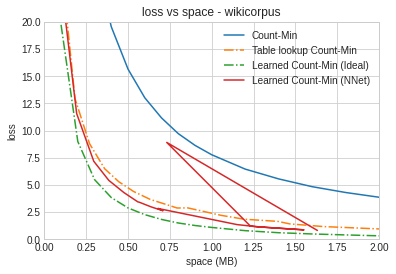

In [24]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.0052]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()